### The wind project

In [3]:
pip install psycopg2-binary

     |████████████████████████████████| 2.2 MB 4.5 MB/s eta 0:00:01
You should consider upgrading via the '/Users/luisazevedo/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests

### API's to test

    - 1) OpenWeatherMap API (https://openweathermap.org/api) - needs credit card details
    - 2) Weatherbit API (https://www.weatherbit.io/api/historical-weather-hourly)
    - 3) AccuWeather API
    - 4) Open-Meteo API https://open-meteo.com/en/docs/historical-weather-api

## Weatherbit API

In [8]:
def get_hourly_data(params, api_key):
    lat = params["lat"]
    long = params["long"]
    start_dt = params["start_date"]
    end_dt = params["end_date"]
    tz = params["tz"]
    key = api_key
    
    get_body = f"https://api.weatherbit.io/v2.0/history/hourly?lat={lat}&lon={long}&start_date={start_dt}&end_date={end_dt}&tz={tz}&key={api_key}"
    
    resp_full = requests.get(get_body)
    
    return resp_full

In [6]:
API_KEY = "619f25080de04c208fc5ab4222ed9453"

In [11]:
full_body = get_hourly_data(params_1, API_KEY)

In [10]:
params_1 = {"lat":"-3.803",
           "long":"-38.410",
           "start_date":"2023-05-06:05",
           "end_date":"2023-05-06:14",
           "tz":"local"}

In [14]:
full_body.json()

{'error': 'Your API key does not allow access to this endpoint. See https://www.weatherbit.io/pricing.'}

## Open-Meteo API

In [18]:
params_2 = {"lat":"-3.803",
           "long":"-38.410",
           "start_date":"2023-04-15",
           "end_date":"2023-05-06",
           "params":"temperature_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m"}

In [25]:
def get_hourly_data_2(params):
    
    lat = params["lat"]
    long = params["long"]
    start_dt = params["start_date"]
    end_dt = params["end_date"]
    params = params["params"]
    
    get_body = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={long}&start_date={start_dt}&end_date={end_dt}&hourly={params}"
    
    resp_full = requests.get(get_body)
    
    body = resp_full.json()
    
    return body

In [26]:
body_test = get_hourly_data_2(params_2)

In [30]:
df_1 = pd.DataFrame(body_test['hourly'])

In [39]:
len(df_1)

528

In [36]:
df_1.sort_values(by = 'time').tail(70)

,time,temperature_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m
458,2023-05-04T02:00,NaN,NaN,NaN,NaN,NaN,NaN
459,2023-05-04T03:00,NaN,NaN,NaN,NaN,NaN,NaN
460,2023-05-04T04:00,NaN,NaN,NaN,NaN,NaN,NaN
461,2023-05-04T05:00,NaN,NaN,NaN,NaN,NaN,NaN
462,2023-05-04T06:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
523,2023-05-06T19:00,NaN,NaN,NaN,NaN,NaN,NaN
524,2023-05-06T20:00,NaN,NaN,NaN,NaN,NaN,NaN
525,2023-05-06T21:00,NaN,NaN,NaN,NaN,NaN,NaN
526,2023-05-06T22:00,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_1.set_index("time", inplace=True)

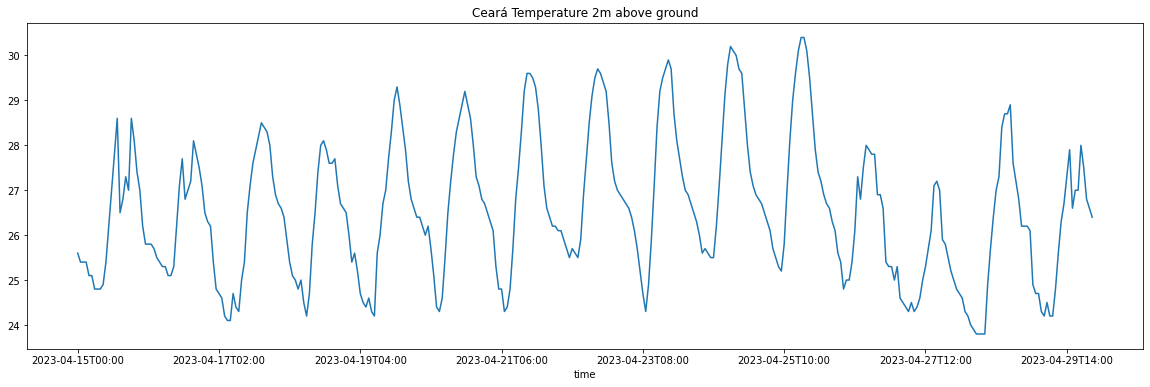

In [46]:
plt.figure(figsize=(20,6))
plt.title("Ceará Temperature 2m above ground")
df_1.temperature_2m.plot()
plt.show()

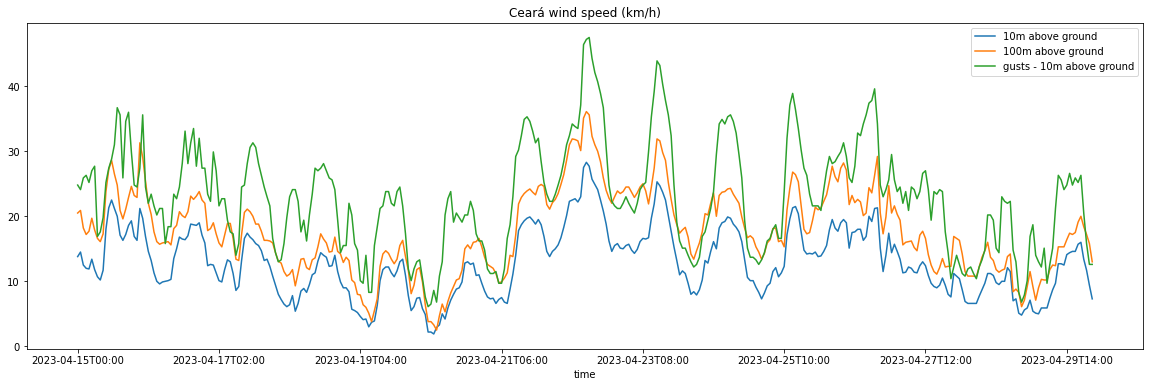

In [49]:
plt.figure(figsize=(20,6))
plt.title("Ceará wind speed (km/h)")
df_1.windspeed_10m.plot(label = '10m above ground')
df_1.windspeed_100m.plot(label = '100m above ground')
df_1.windgusts_10m.plot(label = 'gusts - 10m above ground')
plt.legend()
plt.show()

In [50]:
df_1[~df_1.winddirection_100m.isna()].head()

,temperature_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m
time,,,,,,
2023-04-15T00:00,25.6,13.8,20.5,99.0,101.0,24.8
2023-04-15T01:00,25.4,14.5,20.9,104.0,105.0,24.1
2023-04-15T02:00,25.4,12.5,18.2,108.0,108.0,25.9
2023-04-15T03:00,25.4,12.0,17.2,111.0,110.0,26.3
2023-04-15T04:00,25.1,11.9,17.7,119.0,117.0,25.2


### Using this API, populate PostgreSQL local DB with data

In [52]:
def pgsql_connect(user, password, host, port, database):
    
    conn = psycopg2.connect(user = user,
                            password = password,
                            host = host,
                            port = port,
                            database = database)
    return conn

In [54]:
conn = pgsql_connect("postgres", "pass", "localhost", "5462", "postgres")

In [55]:
conn.status

1

In [57]:
import psycopg2.extras as extras
  
def execute_values(conn, df, table):
  
    tuples = [tuple(x) for x in df.to_numpy()]
  
    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("the dataframe is inserted")
    cursor.close()
  
  
#execute_values(conn, df, 'fossil_fuels_c02')

In [60]:
df_1.columns

Index(['time', 'temperature_2m', 'windspeed_10m', 'windspeed_100m',
       'winddirection_10m', 'winddirection_100m', 'windgusts_10m'],
      dtype='object')

In [59]:
df_1.reset_index(inplace=True)

In [61]:
df_1.rename(columns = {'time':'timestamp',
                       'temperature_2m':'temperature_2',
                       'windspeed_10m':'speed_10',
                       'windspeed_100m':'speed_100',
                       'winddirection_10m':'direction_10',
                       'winddirection_100m':'direction_100',
                       'windgusts_10m':'gusts_10'}, inplace = True)

In [65]:
execute_values(conn, df_1[['timestamp','temperature_2']], 'wind_project.temperature')

the dataframe is inserted


In [67]:
execute_values(conn, df_1.drop(columns = 'temperature_2'), 'wind_project.wind')

the dataframe is inserted


### Now it's time for Grafana visuals (in docker)